In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed


  Signal_Date     Action  Exec_Date  Exec_Price_Raw  Exec_Price_eff  \
0  2022-11-21        BUY 2022-11-22      146.069952      146.142987   
1  2022-11-29       SELL 2022-11-30      139.433543      139.363826   
2  2022-12-01        BUY 2022-12-02      143.930162      144.002127   
3  2022-12-15  STOP LOSS 2022-12-16      134.789065      134.721670   
4  2023-02-03        BUY 2023-02-06      150.448218      150.523442   

   Shares_After   Cash_After  commission  shares_delta  
0     34.213068  4999.000000         1.0     34.213068  
1      0.000000  9766.064093         1.0    -34.213068  
2     33.909444  4882.032046         1.0     33.909444  
3      0.000000  9449.368961         1.0    -33.909444  
4     21.453020  6219.186543         1.0     21.453020  
                 Close       MA_20       MA_50  Signal     Portfolio
Date                                                                
2025-08-15  231.589996  216.640647  209.375384       0  10279.187538
2025-08-18  230.889999  

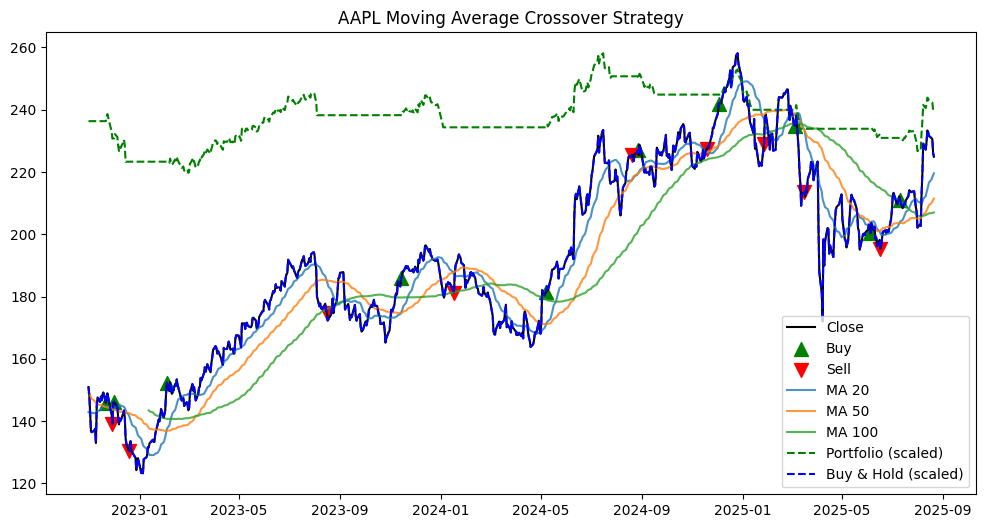

In [10]:
slippage_bps = 0.0005
commission_model = {
    "type": "flat_per_trade",
    "flat_fee":1.00,
    "per_share_fee":0.005,
    "pct_fee":0.0001
}
aloc_frac = 0.50
max_capital_frac = 0.80
vol_target = 0.10
vol_lookback = 30
eps = 1e-12
profit_pct = 0.30
loss_pct = 0.05
trailing_stop = 0.07

def effective_price(side, raw_px, slippage_bps=slippage_bps):
    if side == "BUY":
        return raw_px*(1 + slippage_bps)
    elif side == "SELL":
        return raw_px*(1 - slippage_bps)
    else :
        return ValueError("side must be buy or sell")

def commission_value(model, shares, px_eff):
    t = model["type"]
    if t == "flat_per_trade":
        return float(model.get("flat_fee", 0.0))
    elif t == "per_share":
        return float(model.get("per_share_fee", 0.0)) * float(shares)
    elif t == "percent_notional":
        return float(model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
    else :
        return ValueError("unknown commison model")


df = yf.download("AAPL", period="3y", auto_adjust=True)

df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

df["MA_20"] = df["Close"].rolling(window=20).mean()
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["MA_100"] = df["Close"].rolling(window=100).mean()

df["Signal"] = 0
df.loc[(df["MA_20"] > df["MA_50"]) & (df["MA_20"].shift(1) <= df["MA_50"].shift(1)), "Signal"] = 1  # Buy
df.loc[(df["MA_50"] > df["MA_20"]) & (df["MA_50"].shift(1) <= df["MA_20"].shift(1)), "Signal"] = -1 # Sell


df = df.dropna(subset=["MA_20", "MA_50"])

df["ExecPrice"] = df["Open"].shift(-1)
df = df.dropna(subset=["ExecPrice"])

starting_cash = 10000
cash = starting_cash
shares_held = 0
portfolio = []
trades = []
total_commission_paid = 0.0
total_slippage_cost = 0.0
peak_price = 0.0
entry_price = 0.0

daily_ret = df["Close"].pct_change()
#print(daily_ret)
df["anl_vol"] = daily_ret.rolling(vol_lookback).std() * np.sqrt(252)
exp_flag = []

for i in range(len(df)):
    current_price = df["Close"].iloc[i]
    signal = df["Signal"].iloc[i]
    exec_price = df["ExecPrice"].iloc[i]

    equity = cash + (shares_held * current_price)
    portfolio.append(equity)

    if shares_held > 0:
        exp_flag.append(1)
    else:
        exp_flag.append(0)

    if shares_held > 0:
        peak_price = (max(peak_price, current_price))

        if current_price <= entry_price*(1 - loss_pct):
            px_eff = effective_price("SELL", exec_price, slippage_bps)
            shares_to_sell = shares_held
            proceeds = shares_to_sell * px_eff
            comm = commission_value(commission_model, shares_to_sell, px_eff)

            cash += proceeds - comm
            shares_held = 0
            total_commission_paid += comm
            total_slippage_cost += (exec_price - px_eff) * shares_to_sell
            shares_delta = -shares_to_sell
            trades.append((df.index[i], "STOP LOSS", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = 0.0
            peak_price = 0.0
            continue

        elif current_price >= entry_price*(1+profit_pct):
             px_eff = effective_price("SELL", exec_price, slippage_bps)
             shares_to_sell = shares_held
             proceeds = shares_to_sell * px_eff
             comm = commission_value(commission_model, shares_to_sell, px_eff)

             cash += proceeds - comm
             shares_held = 0
             total_commission_paid += comm
             total_slippage_cost += (exec_price - px_eff) * shares_to_sell
             shares_delta = -shares_to_sell
             trades.append((df.index[i], "TAKE PROFIT", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
             entry_price = 0.0
             peak_price = 0.0
             continue

        elif current_price <= peak_price * (1 - trailing_stop):
            px_eff = effective_price("SELL", exec_price, slippage_bps)
            shares_to_sell = shares_held
            proceeds = shares_to_sell * px_eff
            comm = commission_value(commission_model, shares_to_sell, px_eff)

            cash += proceeds - comm
            shares_held = 0
            total_commission_paid += comm
            total_slippage_cost += (exec_price - px_eff) * shares_to_sell
            shares_delta = -shares_to_sell
            trades.append((df.index[i], "TRAILING STOP", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = 0.0
            peak_price = 0.0
            continue

    # Buy signal
    if signal == 1:
        fixed_frac = aloc_frac

        vol_today = df["anl_vol"].iloc[i]
        if pd.notna(vol_today) and vol_today > 0:
            vol_frac = vol_target / max(vol_today, eps)
        else :
            vol_frac = fixed_frac
        
        target_frac = min(fixed_frac, vol_frac, max_capital_frac)
        target_value = target_frac * equity
        px_eff = effective_price("BUY", exec_price, slippage_bps)
        target_shares = target_value / px_eff
        shares_delta = max(target_shares - shares_held, 0.0)
        comm = commission_value(commission_model, shares_delta ,px_eff)

        if shares_delta * px_eff + comm > cash:
            shares_delta = max((cash-comm)/px_eff, 0.0)
        if shares_delta == 0.0:
            comm = 0.0
        
        cash -= shares_delta * px_eff + comm
        shares_held += shares_delta
        total_commission_paid += comm
        total_slippage_cost += (px_eff - exec_price) * shares_delta

        trades.append((df.index[i], "BUY", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
        entry_price = exec_price
        peak_price = exec_price

    
    # Sell signal
    elif signal == -1 and shares_held > 0:
        px_eff = effective_price("SELL", exec_price, slippage_bps)
        shares_to_sell = shares_held
        proceeds = shares_to_sell * px_eff
        comm = commission_value(commission_model, shares_to_sell, px_eff)
        
        cash += proceeds - comm
        shares_held = 0
        total_commission_paid += comm
        total_slippage_cost += (exec_price - px_eff) * shares_to_sell
        shares_delta = -shares_to_sell
        trades.append((df.index[i], "SELL", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
        entry_price = 0.0
        peak_price = 0.0


df["Portfolio"] = portfolio
trades_df = pd.DataFrame(trades, columns=[
    "Signal_Date", "Action", "Exec_Date", "Exec_Price_Raw", "Exec_Price_eff", "Shares_After", "Cash_After", "commission", "shares_delta"
])
print(trades_df.head(5))

print(df[["Close", "MA_20", "MA_50", "Signal", "Portfolio"]].tail())
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]

shares_bh = starting_cash / df["Close"].iloc[0]
df["BuyHold"] = shares_bh * df["Close"]

# === Performance Metrics Function ===
def performance_metrics(portfolio_values, daily_returns):
    total_return = (portfolio_values[-1] - starting_cash) / starting_cash
    avg_daily = daily_returns.mean()
    std_daily = daily_returns.std()
    annual_return = (1 + avg_daily)**252 - 1
    sharpe = (avg_daily / std_daily) * np.sqrt(252) if std_daily > 0 else np.nan
    cummax = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cummax) / cummax
    max_dd = drawdowns.min()
    return total_return, annual_return, sharpe, max_dd

# === Calculate Metrics ===
strategy_metrics = performance_metrics(df["Portfolio"].values, df["Portfolio"].pct_change().dropna())
bh_metrics = performance_metrics(df["BuyHold"].values, df["BuyHold"].pct_change().dropna())
exposure_pct = np.mean(exp_flag)
traded_notional = (trades_df["shares_delta"].abs() * trades_df["Exec_Price_eff"]).sum()
avg_equity = float(df["Portfolio"].mean())
turnover = traded_notional / max(avg_equity, eps)

# === Create Comparison Report ===
report = pd.DataFrame({
    "Strategy": strategy_metrics,
    "Buy & Hold": bh_metrics
}, index=["Total Return", "Annualized Return", "Sharpe Ratio", "Max Drawdown"])

print("\n=== Performance Comparison ===")
print(report)
print(f"\nTotal trades: {len(trades_df)} | Total commissions: ${total_commission_paid:.2f} | "
      f"Total slippage cost: ${total_slippage_cost:.2f}")
print(f"Turnover: {turnover:.2f}x over the period")
print(f"Exposure: {exposure_pct:.2%}")




# === Plot ===
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Close", color="black")
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="Buy", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="Sell", s=100)
plt.plot(df.index, df["MA_20"], label="MA 20", alpha=0.8)
plt.plot(df.index, df["MA_50"], label="MA 50", alpha=0.8)
plt.plot(df.index, df["MA_100"], label="MA 100", alpha=0.8)
plt.plot(df.index, df["Portfolio"]/max(df["Portfolio"])*max(df["Close"]), 
         label="Portfolio (scaled)", linestyle="--", color="green")  # scaled for visibility
plt.plot(df.index, df["BuyHold"]/df["BuyHold"].iloc[0]*df["Close"].iloc[0],
         label="Buy & Hold (scaled)", linestyle="--", color="blue")
plt.legend()
plt.title("AAPL Moving Average Crossover Strategy")
plt.show()




In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
slippage_bps = 0.0005
commission_model = {
    "type": "flat_per_trade",
    "flat_fee":1.00,
    "per_share_fee":0.005,
    "pct_fee":0.0001
}
aloc_frac = 0.50
max_capital_frac = 0.80
vol_target = 0.10
vol_lookback = 30
eps = 1e-12
profit_pct = 0.30
loss_pct = 0.10
trailing_stop = 0.20
starting_cash = 10000

# MA pairs to test
ma_pairs = [(10,30), (20,50), (50,200), (5,100)]

# === Helper functions ===
def effective_price(side, raw_px, slippage_bps=slippage_bps):
    if side == "BUY":
        return raw_px*(1 + slippage_bps)
    elif side == "SELL":
        return raw_px*(1 - slippage_bps)
    else :
        raise ValueError("side must be buy or sell")

def commission_value(model, shares, px_eff):
    t = model["type"]
    if t == "flat_per_trade":
        return float(model.get("flat_fee", 0.0))
    elif t == "per_share":
        return float(model.get("per_share_fee", 0.0)) * float(shares)
    elif t == "percent_notional":
        return float(model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
    else :
        raise ValueError("unknown commison model")

def performance_metrics(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    total_return = (portfolio_values[-1] - starting_cash) / starting_cash
    daily_returns = pd.Series(portfolio_values).pct_change().dropna()
    avg_daily = daily_returns.mean()
    std_daily = daily_returns.std()
    annual_return = (1 + avg_daily)**252 - 1
    sharpe = (avg_daily / std_daily) * np.sqrt(252) if std_daily > 0 else np.nan
    cummax = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cummax) / cummax
    max_dd = drawdowns.min()
    return total_return, annual_return, sharpe, max_dd

# === Load data ===
df_orig = yf.download("AAPL", period="3y", auto_adjust=True)
df_orig.columns = [col[0] if isinstance(col, tuple) else col for col in df_orig.columns]

# === Prepare summary table ===
summary_rows = []

# === Loop over MA pairs ===
for short_ma, long_ma in ma_pairs:
    df = df_orig.copy()
    df["MA_short"] = df["Close"].rolling(short_ma).mean()
    df["MA_long"] = df["Close"].rolling(long_ma).mean()
    
    df["Signal"] = 0
    df.loc[(df["MA_short"] > df["MA_long"]) & (df["MA_short"].shift(1) <= df["MA_long"].shift(1)), "Signal"] = 1
    df.loc[(df["MA_long"] > df["MA_short"]) & (df["MA_long"].shift(1) <= df["MA_short"].shift(1)), "Signal"] = -1

    df = df.dropna(subset=["MA_short", "MA_long"])
    df["ExecPrice"] = df["Open"].shift(-1)
    df = df.dropna(subset=["ExecPrice"])

    cash = starting_cash
    shares_held = 0
    portfolio = []
    trades = []
    total_commission_paid = 0.0
    total_slippage_cost = 0.0
    peak_price = 0.0
    entry_price = 0.0
    exp_flag = []

    for i in range(len(df)):
        current_price = df["Close"].iloc[i]
        signal = df["Signal"].iloc[i]
        exec_price = df["ExecPrice"].iloc[i]

        equity = cash + (shares_held * current_price)
        portfolio.append(equity)
        exp_flag.append(1 if shares_held > 0 else 0)

        # Check risk exits if in position
        if shares_held > 0:
            peak_price = max(peak_price, current_price)
            exit_reason = None

            if current_price <= entry_price*(1 - loss_pct):
                exit_reason = "STOP LOSS"
            elif current_price >= entry_price*(1 + profit_pct):
                exit_reason = "TAKE PROFIT"
            elif current_price <= peak_price*(1 - trailing_stop):
                exit_reason = "TRAILING STOP"

            if exit_reason:
                px_eff = effective_price("SELL", exec_price)
                proceeds = shares_held * px_eff
                comm = commission_value(commission_model, shares_held, px_eff)

                cash += proceeds - comm
                shares_delta = -shares_held
                trades.append((df.index[i], exit_reason, df.index[i+1], float(exec_price), px_eff, 0.0, float(cash), comm, shares_delta))

                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_held
                shares_held = 0
                entry_price = 0.0
                peak_price = 0.0
                continue

        # Process MA signals
        if signal == 1:
            vol_today = df["Close"].pct_change().rolling(vol_lookback).std().iloc[i] * np.sqrt(252)
            fixed_frac = aloc_frac
            vol_frac = vol_target / max(vol_today, eps) if pd.notna(vol_today) else fixed_frac
            target_frac = min(fixed_frac, vol_frac, max_capital_frac)
            target_value = target_frac * equity
            px_eff = effective_price("BUY", exec_price)
            target_shares = target_value / px_eff
            shares_delta = max(target_shares - shares_held, 0.0)
            comm = commission_value(commission_model, shares_delta ,px_eff)

            if shares_delta * px_eff + comm > cash:
                shares_delta = max((cash-comm)/px_eff, 0.0)
            if shares_delta > 0:
                cash -= shares_delta * px_eff + comm
                shares_held += shares_delta
                total_commission_paid += comm
                total_slippage_cost += (px_eff - exec_price) * shares_delta
                entry_price = exec_price
                peak_price = exec_price
                trades.append((df.index[i], "BUY", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))

        elif signal == -1 and shares_held > 0:
            px_eff = effective_price("SELL", exec_price)
            proceeds = shares_held * px_eff
            comm = commission_value(commission_model, shares_held, px_eff)
            cash += proceeds - comm
            trades.append((df.index[i], "SELL", df.index[i+1], float(exec_price), px_eff, 0.0, float(cash), comm, -shares_held))
            total_commission_paid += comm
            total_slippage_cost += (exec_price - px_eff) * shares_held
            shares_held = 0
            entry_price = 0.0
            peak_price = 0.0

    # Calculate performance
    total_ret, ann_ret, sharpe, max_dd = performance_metrics(portfolio)
    exposure_pct = np.mean(exp_flag)
    traded_notional = sum([abs(t[8])*t[4] for t in trades])
    avg_equity = np.mean(portfolio)
    turnover = traded_notional / max(avg_equity, eps)

    summary_rows.append({
        "Short_MA": short_ma,
        "Long_MA": long_ma,
        "Total Return": total_ret,
        "Annualized Return": ann_ret,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Turnover": turnover,
        "Exposure": exposure_pct,
        "Total Trades": len(trades),
        "Total Commissions": total_commission_paid,
        "Total Slippage": total_slippage_cost
    })

# === Save summary table to CSV ===
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("ma_backtest_summary.csv", index=False)
print(summary_df)


[*********************100%***********************]  1 of 1 completed

   Short_MA  Long_MA  Total Return  Annualized Return  Sharpe Ratio  \
0        10       30      0.014442           0.007397      0.106916   
1        20       50      0.011862           0.006882      0.094483   
2        50      200     -0.030241          -0.012457     -0.232559   
3         5      100      0.141053           0.055313      0.704145   

   Max Drawdown   Turnover  Exposure  Total Trades  Total Commissions  \
0     -0.119299  12.371229  0.567680            31               31.0   
1     -0.122026   8.234325  0.566761            19               19.0   
2     -0.093835   0.626648  0.362816             2                2.0   
3     -0.134061   7.408727  0.596330            17               17.0   

   Total Slippage  
0       63.626544  
1       40.960365  
2        3.143760  
3       42.556535  


[*********************100%***********************]  1 of 1 completed

Backtest Metrics: {'Max Drawdown': -0.1035, 'Sharpe Ratio': -0.0169, 'Annualized Volatility': 0.0565, 'CAGR': -0.0025, 'Total Return': -0.0071}
Buy & Hold Metrics: {'Max Drawdown': -0.3336, 'Sharpe Ratio': 0.6588, 'Annualized Volatility': 0.273, 'CAGR': 0.1525, 'Total Return': 0.4898}
                 Close       MA_20       MA_50  Signal     Portfolio
Date                                                                
2025-08-15  231.589996  216.640647  209.375384       0  10082.080224
2025-08-18  230.889999  217.573191  209.985132       0  10066.089432
2025-08-19  230.559998  218.393343  210.522556       0  10058.550841
2025-08-20  226.009995  218.998482  211.018323       0   9954.610170
2025-08-21  224.899994  219.567598  211.467518       0   9929.253218
  Signal_Date     Action  Exec_Date  Exec_Price_Raw  Exec_Price_eff  \
0  2022-11-21        BUY 2022-11-22      146.069967      146.143002   
1  2022-11-29       SELL 2022-11-30      139.433514      139.363797   
2  2022-12-01     

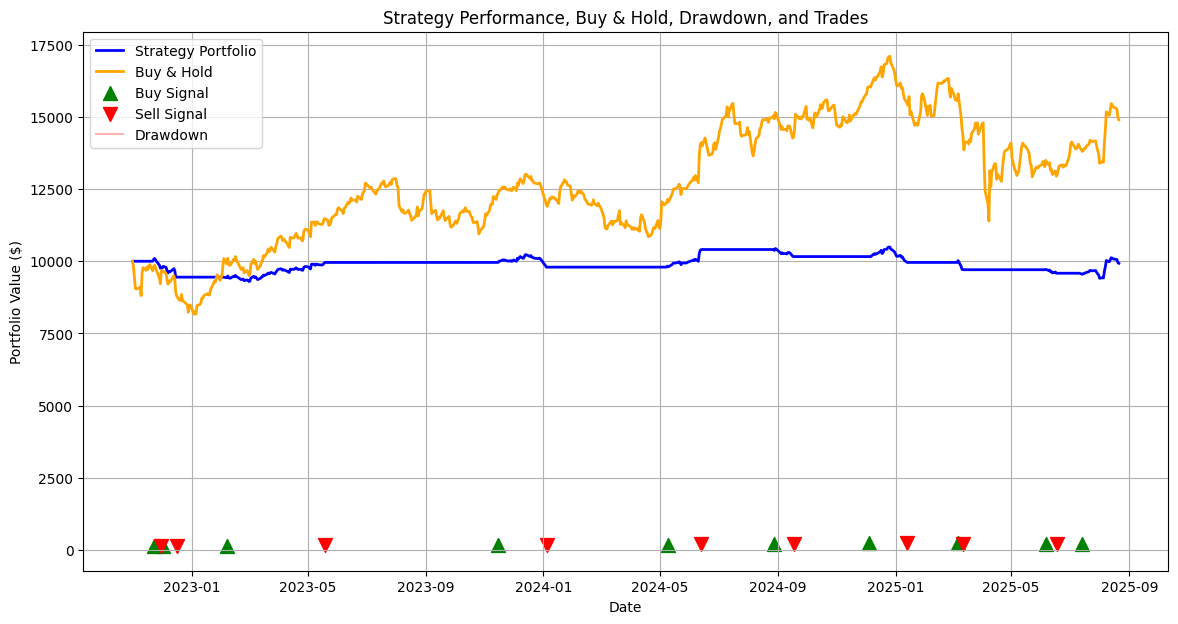

In [19]:
slippage_bps = 0.0005
commission_model = {
    "type": "flat_per_trade",
    "flat_fee":1.00,
    "per_share_fee":0.005,
    "pct_fee":0.0001
}
aloc_frac = 0.50
max_capital_frac = 0.80
vol_target = 0.10
vol_lookback = 30
eps = 1e-12
profit_pct = 0.15
loss_pct = 0.05
trailing_stop = 0.075
starting_cash = 10000


def effective_price(side, raw_px, slippage_bps=slippage_bps):
    if side == "BUY":
        return raw_px*(1 + slippage_bps)
    elif side == "SELL":
        return raw_px*(1 - slippage_bps)
    else :
        return ValueError("side must be buy or sell")

def commission_value(model, shares, px_eff):
    t = model["type"]
    if t == "flat_per_trade":
        return float(model.get("flat_fee", 0.0))
    elif t == "per_share":
        return float(model.get("per_share_fee", 0.0)) * float(shares)
    elif t == "percent_notional":
        return float(model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
    else :
        return ValueError("unknown commison model")

def run_backtest(ticker, period="3y"):
    # download the data
    df = yf.download(ticker, period=period, auto_adjust=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    
    # calculate the rolling avg
    df["MA_20"] = df["Close"].rolling(window=20).mean()
    df["MA_50"] = df["Close"].rolling(window=50).mean()
    df["MA_100"] = df["Close"].rolling(window=100).mean()
    
    # define the signal
    df["Signal"] = 0
    df.loc[(df["MA_20"] > df["MA_50"]) & (df["MA_20"].shift(1) <= df["MA_50"].shift(1)), "Signal"] = 1  # Buy
    df.loc[(df["MA_50"] > df["MA_20"]) & (df["MA_50"].shift(1) <= df["MA_20"].shift(1)), "Signal"] = -1 # Sell

    # clean and execution price (next day open)
    df = df.dropna(subset=["MA_20", "MA_50"])
    df["ExecPrice"] = df["Open"].shift(-1)
    df = df.dropna(subset=["ExecPrice"])

    # staring portfolio
    cash = starting_cash
    shares_held = 0.0
    portfolio = []
    trades = []
    total_commission_paid = 0.0
    total_slippage_cost = 0.0
    peak_price = 0.0
    entry_price = 0.0

    daily_ret = df["Close"].pct_change()
    #print(daily_ret)
    df["anl_vol"] = daily_ret.rolling(vol_lookback).std() * np.sqrt(252)
    exp_flag = []

    for i in range(len(df)):
        current_price = df["Close"].iloc[i]
        signal = df["Signal"].iloc[i]
        exec_price = df["ExecPrice"].iloc[i]
        
        equity = cash + (shares_held * current_price)
        portfolio.append(equity)

        if shares_held > 0:
            exp_flag.append(1)
        else:
            exp_flag.append(0)

        if shares_held > 0:
            peak_price = (max(peak_price, current_price))

            if current_price <= entry_price*(1 - loss_pct):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "STOP LOSS", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

            elif current_price >= entry_price*(1+profit_pct):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "TAKE PROFIT", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

            elif current_price <= peak_price * (1 - trailing_stop):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "TRAILING STOP", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

    # Buy signal
        if signal == 1:
            fixed_frac = aloc_frac

            vol_today = df["anl_vol"].iloc[i]
            if pd.notna(vol_today) and vol_today > 0:
                vol_frac = vol_target / max(vol_today, eps)
            else :
                vol_frac = fixed_frac
        
            target_frac = min(fixed_frac, vol_frac, max_capital_frac)
            target_value = target_frac * equity
            px_eff = effective_price("BUY", exec_price, slippage_bps)
            target_shares = target_value / px_eff
            shares_delta = max(target_shares - shares_held, 0.0)
            comm = commission_value(commission_model, shares_delta ,px_eff)

            if shares_delta * px_eff + comm > cash:
                shares_delta = max((cash-comm)/px_eff, 0.0)
            if shares_delta == 0.0:
                comm = 0.0
        
            cash -= shares_delta * px_eff + comm
            shares_held += shares_delta
            total_commission_paid += comm
            total_slippage_cost += (px_eff - exec_price) * shares_delta

            trades.append((df.index[i], "BUY", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = exec_price
            peak_price = exec_price

    
    # Sell signal
        elif signal == -1 and shares_held > 0:
            px_eff = effective_price("SELL", exec_price, slippage_bps)
            shares_to_sell = shares_held
            proceeds = shares_to_sell * px_eff
            comm = commission_value(commission_model, shares_to_sell, px_eff)
        
            cash += proceeds - comm
            shares_held = 0
            total_commission_paid += comm
            total_slippage_cost += (exec_price - px_eff) * shares_to_sell
            shares_delta = -shares_to_sell
            trades.append((df.index[i], "SELL", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = 0.0
            peak_price = 0.0
    df["Portfolio"] = portfolio
    trades_df = pd.DataFrame(trades, columns=[
    "Signal_Date", "Action", "Exec_Date", "Exec_Price_Raw", "Exec_Price_eff", "Shares_After", "Cash_After", "commission", "shares_delta"
    ])
    print(df[["Close", "MA_20", "MA_50", "Signal", "Portfolio"]].tail())
    buy_signals = df[df["Signal"] == 1]
    sell_signals = df[df["Signal"] == -1]

    shares_bh = starting_cash / df["Close"].iloc[0]
    df["BuyHold"] = shares_bh * df["Close"]
    
        
    return df, trades_df  # for now, just return the prepared frame

def performance_metrics(portfolio_series):
    daily_ret = portfolio_series.pct_change()
    
    # Annualized volatility
    ann_vol = float(daily_ret.std() * np.sqrt(252))
    
    # CAGR
    years = (portfolio_series.index[-1] - portfolio_series.index[0]).days / 365
    cagr = float((portfolio_series.iloc[-1] / portfolio_series.iloc[0])**(1/years) - 1)
    
    # Sharpe ratio
    sharpe = float((daily_ret.mean() * 252) / ann_vol)
    
    # Maximum Drawdown
    cummax = portfolio_series.cummax()
    drawdown = (portfolio_series - cummax) / cummax
    max_dd = float(drawdown.min())
    
    # Total return
    total_return = float(portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1)
    
    return {
        "Max Drawdown": round(max_dd, 4),
        "Sharpe Ratio": round(sharpe, 4),
        "Annualized Volatility": round(ann_vol, 4),
        "CAGR": round(cagr, 4),
        "Total Return": round(total_return, 4)
    }

bt_metrics = performance_metrics(df["Portfolio"])
bh_metrics = performance_metrics(df["BuyHold"])

print("Backtest Metrics:", bt_metrics)
print("Buy & Hold Metrics:", bh_metrics)
  
df, trades_df = run_backtest("AAPL")
#print(df.head())        # DataFrame with portfolio, signals, etc.
print(trades_df.head()) # DataFrame with executed trades

cummax = df["Portfolio"].cummax()
drawdown = (df["Portfolio"] - cummax) / cummax

plt.figure(figsize=(14,7))

# Main axis: portfolio & buy & hold
plt.plot(df.index, df["Portfolio"], label="Strategy Portfolio", color="blue", lw=2)
plt.plot(df.index, df["BuyHold"], label="Buy & Hold", color="orange", lw=2)

# Plot trades
buy_trades = trades_df[trades_df["Action"]=="BUY"]
sell_trades = trades_df[trades_df["Action"].isin(["SELL","STOP LOSS","TAKE PROFIT","TRAILING STOP"])]

plt.scatter(buy_trades["Exec_Date"], buy_trades["Exec_Price_eff"], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_trades["Exec_Date"], sell_trades["Exec_Price_eff"], marker="v", color="red", s=100, label="Sell Signal")
# Labels and legend
plt.title("Strategy Performance, Buy & Hold, Drawdown, and Trades")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()